In [15]:
def do_setup():
    # How to download competition data to temp folder(data) 
    # unzip it there, then symlink it like its a subdir
    # NOTE: make sure kaggle.json is in /root/.kaggle/

    #remove original symlink from this directory
    !rm ./data
    
    #remove old setup files
    !rm setup.sh

    #create temp holder
    !mkdir /root/data

    #symlink it
    !ln -s /root/data ./data

    #download competition data to temp data folder
    !cd ./data;kaggle competitions download -c paddy-disease-classification

    #unzip it, -q is silent
    !cd ./data;unzip -q paddy-disease-classification.zip

    #setup dotfiles
    !wget "https://raw.githubusercontent.com/CNUClasses/dotfiles/master/setup.sh";chmod 766 setup.sh;source ./setup.sh  
    
import os
if(not os.path.exists('./data/train_images')):
   !chmod 600 /root/.kaggle/kaggle.json
   do_setup()  

In [16]:
#install needed libraries
try: from path import Path
except ModuleNotFoundError:
    !pip install path --quiet
    from path import Path
try: import timm
except ModuleNotFoundError:
    !pip install timm --quiet
    import timm

## Functions, constants, imports

In [17]:
import os
def get_fls(pth, ext=['.png','.jpg']):
    '''
    pth: recursively gather all image files in pth
    return: list of files (with absolute paths)
    '''
    pth=os.path.abspath(pth)       #absolute path
    ext=[ext.lower() for ext in ext]  #make sure lowercase
    res=[]
    for root,dirs,fles in os.walk(pth):
        for fle in fles:
            if os.path.splitext(fle)[1].lower() in ext:
                res.append(os.path.join(root,fle))
    return res

In [18]:
#from https://www.kaggle.com/code/hinepo/transfer-learning-with-timm-models-and-pytorch
class CFG:
    train_path='./data/train_images'   #get train and validation Datasets from here
    test_path='./data/test_images'     #get test set from here
    csv_path='./data/train.csv'
    
    # DEBUG = False
    
    ### input: not configurable
    # IMG_HEIGHT = 28
    # IMG_WIDTH = 28
    # N_CLASS = len(np.unique(train['label']))

    ### split train and validation sets
    split_fraction = 0.2

    ##dataloader
    drop_last=False
    
    ### model
    model_name = 'resnet26d' #'resnet50' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 ...  

    #get a subset of data to work on(start with True until all experiments done
    #and want to train on entire dataset
    subsample_data=False
    BATCH_SIZE= 8 if subsample_data else 32
    N_EPOCHS = 4 if subsample_data else 50
    print_freq = 5

    momentum=0.9
    
    ### set only one to True
    save_best_loss = False
    save_best_accuracy = True

    ### optimizer
    # optimizer = 'adam'
    # optimizer = 'adamw'
    optimizer = 'rmsprop'
    # LEARNING_RATE=0.00001
    LEARNING_RATE_MIN=0.004
    LEARNING_RATE_MAX=0.01
    
    # weight_decay = 0.1 # for adamw
    # l2_penalty = 0.01 # for RMSprop
    # rms_momentum = 0 # for RMSprop

    ### learning rate scheduler (LRS)
    # scheduler = 'ReduceLROnPlateau'
    # # scheduler = 'CosineAnnealingLR'
    # plateau_factor = 0.5
    # plateau_patience = 3
    # cosine_T_max = 4
    # cosine_eta_min = 1e-8
    # verbose = True

    ### train and validation DataLoaders
    # shuffle = False

    ### albumentations
    probability = 0.6

    random_seed = 42

In [19]:
import torch
import pandas as pd
import torch.optim as optim
from tqdm.auto import tqdm
import sklearn
from sklearn.model_selection import train_test_split
sklearn.__version__

'1.1.1'

## Define datasets, dataloader, model, and error function

### Get data

In [20]:
df =pd.read_csv(CFG.csv_path)
df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


## EXPERIMENT ON SUBSET OF DATA

In [21]:
if CFG.subsample_data:
    #stratify dataframe by multiple columns (see Paddy-Multi.ipynb)
    # df, _ = train_test_split(df, test_size=0.5, random_state=0, stratify=df[['label', 'variety']])

#     #get a small dataset to train on
    df=df.iloc[:500,:]

    print(df.shape)

### Define Dataset

In [22]:
# #get a list of files
trn_val_files=get_fls(CFG.train_path)  
tst_files=get_fls(CFG.test_path) 
print(f'Len train={len(trn_val_files)}, length test={len(tst_files)}')

Len train=10407, length test=3469


In [23]:
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms

class MultiTaskDatasetTest(Dataset):
    '''
    Use for test dataset, all files are in img_dir, there is no other information associated with each file               
    '''
    def __init__(self,img_dir,*,transforms=None, target_transform=None):
        self.files=get_fls(img_dir)  #build a list of all the absolute path files
        self.transforms = transforms
        self.target_transform = target_transform  
     
    def __len__(self): return len(self.files)
        
    def __getitem__(self,idx):
        image=read_image(str(self.files[idx]))   #get the image    
        if self.transforms:
            image = self.transforms(image)      
        return image
    
# create a dict to map label strings to tensors
i_to_label=dict(enumerate(df.label.unique()))
label_to_i={v:i for i,v in i_to_label.items()}
#create another to map variety strings to tensors
i_to_variety=dict(enumerate(df.variety.unique()))
variety_to_i={v:i for i,v in i_to_variety.items()}
class MultiTaskDatasetTrain(Dataset): 
    '''
    Use for train and validation datasets, use when you know both the label and variety               
    '''
    def __init__(self,img_dir,*,df=None,transforms=None, target_transform=None):
        '''
        df: contains info to build train and validation datasets
        img_dir: where images are ex "./data/train_images"
        transforms: list of transforms to apply      
        '''
        super().__init__()
        self.image_ids=df.loc[:,'image_id'].tolist()
        self.labels=df.loc[:,'label'].tolist()
        self.varietys=df.loc[:,'variety'].tolist()
        self.files=[]
        for image_id,label in zip(self.image_ids, self.labels):
            self.files.append(os.path.join(img_dir,label,image_id))
        assert len(self.files)==len(self.labels) and len(self.files)==len(self.varietys), f"files,labels and variety must be same length"

        #now convert the labels and varieties to numbers
        self.labels=list(map(label_to_i.get,self.labels))
        self.varietys=list(map(variety_to_i.get,self.varietys))
 
        self.transforms = transforms
        self.target_transform = target_transform       
        # self.size = len(self.files)

    def __len__(self): return len(self.files)

    def __getitem__(self,idx):
        #dealing with the image
        image=read_image(str(self.files[idx]))
        
        lbl=self.labels[idx]
        variety=self.varietys[idx]
        
        if self.transforms:
            image = self.transforms(image)
        # img = PIL.Image.open(self.paths[idx]).convert('RGB')
        # img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        # img = img.apply_tfms(self.transform, size = self.size)
        # img = self.norm(img.data)
        
        return image,lbl,variety
    
    def display(self,idx):
        image,lbl,variety=self[idx]
        print(f'{self.i_to_label[lbl]}')
        print(f'{self.i_to_variety[variety]}')
        # from fastai.vision.all import *
        # img=PILImage.create(files[0])
        # print(img.size)
        # img.to_thumb(128)



### Train,Val and Test Datasets

#### Get train, val df by stratified split on df

In [24]:
#stratify dataframe by multiple columns (see Paddy-Multi.ipynb)
train, val = train_test_split(df, test_size=CFG.split_fraction, random_state=0, stratify=df[['label', 'variety']])
len(train) + len(val)

10407

#### Get a list of transforms that the original model used

In [25]:
cfg=timm.data.resolve_data_config({}, model=CFG.model_name, verbose=True)
cfg

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875}

#### Create Datasets

In [26]:
import torchvision.transforms as transforms

image_size=cfg['input_size'][-2:] #get just the height and width (not the channels)
mean=cfg['mean'] #mean and std come from the model
std=cfg['std']

train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ConvertImageDtype(torch.float),
        # transforms.ToTensor(), #not needed if already a tensor
        transforms.Normalize(mean=mean,std=std)     #mean and std come from the model
    ])
val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean,std=std)
])

trn_dataset = MultiTaskDatasetTrain(CFG.train_path,df=train,transforms=train_transforms) #use train df
val_dataset = MultiTaskDatasetTrain(CFG.train_path,df=val,transforms=val_transforms)   #use val df
test_dataset=MultiTaskDatasetTest(CFG.test_path, transforms=val_transforms)            #test set


print(f'Number train images={len(trn_dataset)}, number validation={len(val_dataset)}, and number test images={len(test_dataset)}')

if(not CFG.subsample_data):
    assert(len(trn_dataset)+len(val_dataset)==len(trn_val_files))
    assert(len(test_dataset)==len(tst_files))

Number train images=8325, number validation=2082, and number test images=3469


### Create DataLoaders

In [27]:
from torch.utils.data import DataLoader
trn_dl=DataLoader(trn_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2,drop_last=CFG.drop_last) #drop last to avoid crash
val_dl=DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2,drop_last=CFG.drop_last)


#### Check on DataLoader

In [28]:
import matplotlib.pyplot as plt
imgs,lbls,varieties = next(iter(val_dl))
print(f"Feature batch shape: {imgs.size()}")
print(f"Labels batch shape: {lbls.size()}")
print(f"Varieties batch shape: {varieties.size()}")

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Varieties batch shape: torch.Size([32])


#### Show the images <mark> is this correct?

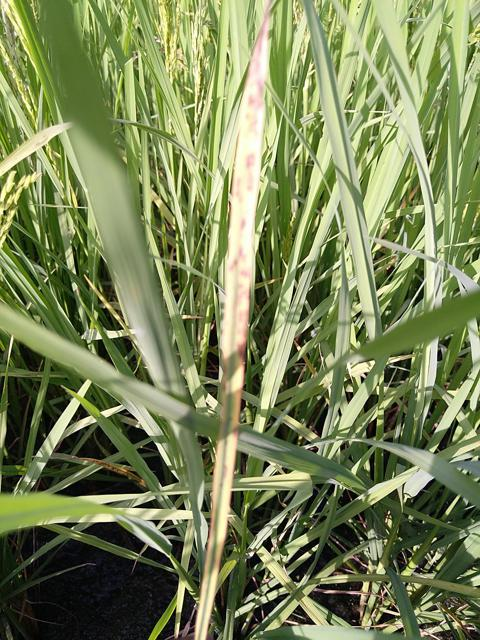

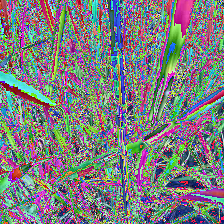

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: brown_spot
Variety: ADT45


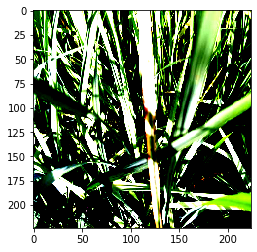

In [29]:
#look at original image and new one
from PIL import Image
import numpy as np
img1,lbl,variety = trn_dataset[0]

# original image (PIL)
Image.open(trn_dataset.files[0]).show()

#see returned as a PIL image
import torchvision.transforms as T
transform = T.ToPILImage()
transform(img1).show()

#show as raw tensor
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
show(img1)

print(f"Label: {i_to_label[lbl]}")
print(f"Variety: {i_to_variety[variety]}")

### Custom Loss function

In [30]:
class DiseaseAndTypeClassifierLoss(nn.Module):
    def __init__(self):
        super(DiseaseAndTypeClassifierLoss, self).__init__()

    def forward(self, pred_labels,pred_varieties, correct_labels,correct_varieties):
        #using crossentropy loss
        criterion = nn.CrossEntropyLoss()
        
        loss_labels= criterion(pred_labels, correct_labels)
        loss_varieties=criterion(pred_varieties, correct_varieties)
    
        return loss_labels , loss_varieties

### Error rate and Accuracy

In [31]:
def acc(preds,lbls):
    '''
    preds:[nxn] tensor
    lbls:[1xn] tensor
    sums number of lbl positions that are equivalent to max pred
    then divides by total number of samples
    returns: float between 0 and 1
    '''
    return ((torch.argmax(preds,dim=1)==lbls).sum()/len(lbls)).item()
def error_rate(preds,lbls):
    return(1-acc(preds,lbls))


### Define Multi Head Model (2 output params)

In [32]:
import torch.nn as nn
class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self,tmodel):
        '''
        tmodel: pretrained model
        ex:
        model_name='resnet26d'
        tmodel=timm.create_model(model_name, pretrained=True)
        m1=DiseaseAndTypeClassifier(tmodel)
        
        '''
        super().__init__()
        self.m = tmodel
        # self.m.fc=nn.Sequential(
        #     nn.Linear(in_features=self.m.get_classifier().in_features,out_features=512, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(512),
        #     nn.Dropout(0.4))
        self.m.fc=nn.Sequential(
            nn.Linear(in_features=self.m.get_classifier().in_features,out_features=512, bias=False),
            nn.ReLU())
        # self.m.fc=nn.Linear(in_features=self.m.get_classifier().in_features,out_features=512, bias=False)
        self.l1=nn.Linear(in_features=512, out_features=10, bias=False)  #rice type
        self.l2=nn.Linear(in_features=512, out_features=10, bias=False)  #disease
        
    def forward(self,x):       
        x=self.m(x)
        label=self.l1(x)  #disease type
        variety=self.l2(x)  #variety
        return label,variety
      

### Simple training class

In [42]:

class stats():
    def __init__(self,kind='train'):
        self.reset()
        self.kind=kind
        self.best_loss_labels = None
        self.best_loss_varieties = None
        self.best_err_rate_labels =None
        self.best_err_rate_varieties =None
        
    def reset(self):
        self.running_loss_labels = 0.0
        self.running_loss_varieties = 0.0
        self.running_err_rate_labels =0.0
        self.running_err_rate_varieties =0.0
        
    def add(self,loss_labels,loss_varieties,err_rate_labels,err_rate_varieties):
        self.running_loss_labels+=loss_labels
        self.running_loss_varieties+=loss_varieties
        self.running_err_rate_labels+=err_rate_labels
        self.running_err_rate_varieties+=err_rate_varieties
        
    def is_best_loss(self,btch_num):
        '''
        call at end of every epoch to see if we should save model
        '''
        ret=False #assumme worst
        loss_lbls, loss_varieties,err_rate_labels,err_rate_varieties=self.calc_curr_loss(btch_num)
        
        if (self.best_loss_labels is None) or(self.best_loss_labels>loss_lbls):
            self.best_loss_labels=loss_lbls
            if CFG.save_best_loss: ret= True
            
        if (self.best_err_rate_labels is None) or(self.best_err_rate_labels>err_rate_labels):
            self.best_err_rate_labels=err_rate_labels
            if CFG.save_best_accuracy: ret= True   
            
        self.reset()
        return ret
 
    def calc_curr_loss(self,btch_num):
        den=btch_num+1
        return self.running_loss_labels/den,self.running_loss_varieties/den,self.running_err_rate_labels/den,self.running_err_rate_varieties/den
        
    def show(self,btch_num):
        '''
        prints out losses every CFG.print_freq batch
        '''
        if (btch_num%CFG.print_freq==0):
            loss_lbls, loss_varieties,err_rate_labels,err_rate_varieties=self.calc_curr_loss(btch_num)
            print(f'{self.kind}:err_rate_labels={err_rate_labels:.2f},   label_loss={loss_lbls:.2f},  err_rate_varieties={err_rate_varieties:.2f}   varieties_loss={loss_varieties:.2f}', end='\r', flush=True)
    

from torch.optim.lr_scheduler import OneCycleLR       
class Learner():
    def __init__(self,m,lr=CFG.LEARNING_RATE_MIN,momentum=CFG.momentum):
        '''
        m: model to train with
        '''
        #the “safer” approach would be to move the model to the device first and create the optimizer afterwards.
        self.m=m        
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.m.to(self.device)
        self.lr=lr
        self.optimizer=optim.SGD(self.m.parameters(), lr=lr, momentum=momentum)

        self.criterion=DiseaseAndTypeClassifierLoss()
        self.trn_stats=stats()
        self.val_stats=stats('valid')
        
    def learn(self,trn_dl,val_dl, num_epochs=CFG.N_EPOCHS): 
        self.lrs=[]  #used to examine learning rates
        self.scheduler = OneCycleLR(self.optimizer, 
            max_lr = CFG.LEARNING_RATE_MAX, # Upper learning rate boundaries in the cycle for each parameter group
            steps_per_epoch=int(len(trn_dl)),epochs=num_epochs,
            anneal_strategy = 'cos') # Specifies the annealing strategy
 
        for epoch in range(num_epochs):  # loop over the dataset multiple time            
            self._trn_epoch(trn_dl)           
            self._val_epoch(val_dl,epoch)

    def _trn_epoch(self,dl):                                                                                                                          
        self.trn_stats.reset()
        self.m.train()
        
        for i, data in (enumerate(dl)):
            
             # get the inputs, labels is tuple(label, variety)
            imgs,lbls,varietys = data[0].to(self.device),data[1].to(self.device),data[2].to(self.device)
            
            # zero the parameter gradients
            self.optimizer.zero_grad()
 
            # forward + backward + optimize
            pred_lbls,pred_varieties = self.m(imgs)             
            loss_labels , loss_varieties = self.criterion(pred_lbls,pred_varieties, lbls,varietys)
            
            #see https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method
            loss_labels.backward(retain_graph=True)
            loss_varieties.backward()

            #save info                                                                                                             
            self.trn_stats.add(loss_labels.item(),loss_varieties.item(),error_rate(pred_lbls,lbls),error_rate(pred_varieties,varietys))
  
            #adjust weights
            self.optimizer.step()
 
            #adjust learning rate
            self.scheduler.step()
            self.lrs.append( self.scheduler.get_last_lr())
            
            self.trn_stats.show(i)  
        print()
          
    def _val_epoch(self,dl,epoch):                                                                                                                          
        self.val_stats.reset()
        self.m.eval()
        with torch.no_grad():
            for i, data in (enumerate(dl)):

                 # get the inputs, labels is tuple(label, variety)
                imgs,lbls,varietys = data[0].to(self.device),data[1].to(self.device),data[2].to(self.device)

                # forward + backward + optimize
                pred_lbls,pred_varieties = self.m(imgs)             
                loss_labels , loss_varieties = self.criterion(pred_lbls,pred_varieties, lbls,varietys)

                #save info                                                                                                             
                self.val_stats.add(loss_labels.item(),loss_varieties.item(),error_rate(pred_lbls,lbls),error_rate(pred_varieties,varietys))

                self.val_stats.show(i)

            if(self.val_stats.is_best_loss(i)):
                print(f'\nEpoch {epoch}found and saving better model')
                 # save the model's weights and biases 
                torch.save(self.m.state_dict(), f"./DiseaseAndTypeClassifier_ep.pth")               
            print()

### Load and Train Model

In [43]:
%%time
# tmodel=timm.create_model(model_name, pretrained=True)
tmodel=timm.create_model(CFG.model_name, pretrained=True, num_classes=13,global_pool='catavgmax')  #going to replace the 13
m1=DiseaseAndTypeClassifier(tmodel)

lrn=Learner(m1)
lrn.learn(trn_dl,val_dl,num_epochs=5)

train:err_rate_labels=0.51,   label_loss=1.48,  err_rate_varieties=0.28   varieties_loss=0.90
valid:err_rate_labels=0.49,   label_loss=1.78,  err_rate_varieties=0.40   varieties_loss=1.17
Epoch 0found and saving better model

train:err_rate_labels=0.36,   label_loss=1.09,  err_rate_varieties=0.21   varieties_loss=0.66
valid:err_rate_labels=0.47,   label_loss=1.62,  err_rate_varieties=0.29   varieties_loss=0.83
Epoch 1found and saving better model

train:err_rate_labels=0.28,   label_loss=0.87,  err_rate_varieties=0.16   varieties_loss=0.47
valid:err_rate_labels=0.21,   label_loss=0.65,  err_rate_varieties=0.12   varieties_loss=0.45
Epoch 2found and saving better model

train:err_rate_labels=0.20,   label_loss=0.60,  err_rate_varieties=0.10   varieties_loss=0.29
valid:err_rate_labels=0.13,   label_loss=0.38,  err_rate_varieties=0.04   varieties_loss=0.14
Epoch 3found and saving better model

train:err_rate_labels=0.13,   label_loss=0.39,  err_rate_varieties=0.05   varieties_loss=0.15
va

In [55]:
#train a bit more?
lrn.learn(trn_dl,val_dl,num_epochs=2)

train:err_rate_labels=0.13,   label_loss=0.40,  err_rate_varieties=0.05   varieties_loss=0.17
valid:err_rate_labels=0.12,   label_loss=0.38,  err_rate_varieties=0.04   varieties_loss=0.15
train:err_rate_labels=0.12,   label_loss=0.38,  err_rate_varieties=0.05   varieties_loss=0.15
valid:err_rate_labels=0.06,   label_loss=0.20,  err_rate_varieties=0.02   varieties_loss=0.06
Epoch 1found and saving better model



### Lets plot the cyclic learning rate

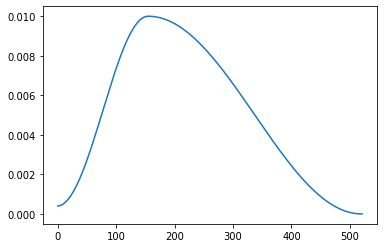

In [53]:
import matplotlib.pyplot as plt
plt.plot(lrn.lrs)

## Predict on the val set 

In [58]:
def get_accuracy(m,dl, verbose=True):
    '''
    returns the models accuracy fro both labl and variety
    
    m1.trained model
    dl: DataLoader with data of interest (train or validation)    
    return: acc_labl,acc_var
    '''
    #where is model (send data to evaluate there)
    device=next(m1.parameters()).device.type  #return cuda if on cuda
    
    m.eval()
    cum_acc_lbl=0
    cum_acc_varietie=0
    for i,data in enumerate(dl):
        img,lbl,variety = data[0].to(device),data[1].to(device),data[2].to(device)
        pred_lbl,pred_varieties = m(img)
        cum_acc_lbl+=acc(pred_lbl,lbl)
        cum_acc_varietie+=acc(pred_varieties,variety)
    acc_labl=(cum_acc_lbl*100)/(i+1)
    acc_var=(cum_acc_varietie*100)/(i+1)
    if verbose: print(f'Accuracy: Label prediction={ acc_labl:.2f}%,  Variety prediction={ acc_var:.2f}')
    return acc_labl,acc_var
    
get_accuracy(m1,val_dl)
    

Accuracy: Label prediction=93.61%,  Variety prediction=98.15


(93.60795454545455, 98.1534090909091)

## Generate submission

In [73]:
#generate sorted list of files
test_dataset=MultiTaskDatasetTest(CFG.test_path, transforms=val_transforms) 
test_dataset.files.sort()

#generate a non_shuffle dataloader
tst_dl=DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=1,drop_last=False)

#where is the model
device = next(m1.parameters()).device.type

#get model predictions
labels=[]
for imgs in tst_dl:
    imgs = imgs.to(device)

    # forward + backward + optimize
    pred_lbls,_ = m1(imgs)
    
    #get the max index
    pred_lbls=torch.argmax(pred_lbls,dim=1).tolist()
    labels=labels+pred_lbls   

In [74]:
#convert indexes to labels
new_labels=[i_to_label[i] for i in labels]
# get a list of files
files=[fle.split('/')[-1] for fle in test_dataset.files]   

In [82]:
with open('./submission.txt','w') as fle:
    fle.write('image_id,label\n')
    for i in range(len(files)):
        fle.write(files[i]+','+new_labels[i]+'\n')

## Experiment

In [ ]:
#where is this model located?
# tmodel1=timm.create_model(model_name, pretrained=True, num_classes=13,global_pool='catavgmax')  #going to replace the 13
# next(tmodel1.parameters()).device.type

#     def _one_epoch(self,dl,training):
#         running_loss_labels = 0.0
#         running_loss_varieties = 0.0
#         running_err_rate_labels =0.0
#         running_err_rate_varieties =0.0
#         is_trn=self.m.training
        
#         # for i, data in (enumerate(tqdm(dl), 0)):
#         print()
#         for i, data in (enumerate(dl)):

#             # get the inputs, labels is tuple(label, variety)
#             imgs,lbls,varietys = data[0].to(self.device),data[1].to(self.device),data[2].to(self.device)
           
#             if training:
#                 # zero the parameter gradients
#                 self.optimizer.zero_grad()
 
#             # forward + backward + optimize
#             pred_lbls,pred_varieties = self.m(imgs)
             
#             loss_labels , loss_varieties = self.criterion(pred_lbls,pred_varieties, lbls,varietys)
            
#             if training:
#                 #see https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method
#                 loss_labels.backward(retain_graph=True)
#                 loss_varieties.backward()

#             running_loss_labels+=loss_labels.item()
#             running_loss_varieties+=loss_varieties.item()
#             running_err_rate_labels+=error_rate(pred_lbls,lbls)
#             running_err_rate_varieties+=error_rate(pred_varieties,varietys)
 
#             #adjust weights
#             self.optimizer.step()

#             if (i%CFG.print_freq==0):
#                 state='train' if is_trn else 'valid' 
#                 print(f'{state}:err_rate_labels={(running_err_rate_labels/(i)):.2f},   label_loss={(running_loss_labels):.2f},   err_rate_varieties={(running_err_rate_varieties/(i)):.2f}   varieties_loss={(running_loss_varieties):.2f},    ', end='\r', flush=True)
#                 running_loss_labels = 0.0
#                 running_loss_varieties = 0.0
        

In [ ]:
# m1.train()
# m1.eval()
# print(f'{m1.training}, {m1.m.training}, {m1.m.fc.training}')

#check shapes
# (next(iter(trn_dl))[-2:])

# m1.eval()
# m1(trn_dataset[0][0].unsqueeze(0))

 #calls forward
# m1(next(iter(trn_dl))[0]) 
# m1(val_dataset[0].unsqueeze(0))

# m1(torch.randn(1,3,224,224))



# criterion=DiseaseAndTypeClassifierLoss()
# optimizer = optim.SGD(m1.parameters(), lr=0.001, momentum=0.9)
# num_epochs=3
# numb_batches_between_prints=1

        
        
# for epoch in range(num_epochs):  # loop over the dataset multiple times

#     running_loss_labels = 0.0
#     running_loss_varieties = 0.0
#     num_batches=len(trn_dl)/trn_dl.batch_size
#     m1.train()
#     for i, data in (enumerate(tqdm(trn_dl), 0)):

#         # get the inputs, labels is tuple(label, variety)
#         imgs,lbls,varietys = data[0].to(device),data[1].to(device),data[2].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         pred_lbls,pred_varieties = m1(imgs)
        
#         #loss
#         # loss = criterion(pred_lbls,pred_varieties, lbls,varietys)
#         # loss.backward()
#         loss_labels , loss_varieties = criterion(pred_lbls,pred_varieties, lbls,varietys)
#         loss_labels.backward()
#         loss_varieties.backward()
        
#         running_loss_labels+=loss_labels.item()
#         running_loss_varieties+=loss_varieties.item()
        
#         #adjust weights
#         optimizer.step()
        
#         if i%numb_batches_between_prints==0:
#             if(
#             print(f'label_loss={running_loss_labels/(numb_batches_between_prints*batch_size):.2f}, \
#                   varieties_loss={running_loss_varieties/(numb_batches_between_prints*batch_size):.2f}', end='\r', flush=True)
#             running_loss_labels = 0.0
#             running_loss_varieties = 0.0
    
#     # m1.eval()
#     # num_batches=len(val_dl)/batch_size
#     # for i, data in (enumerate(tqdm(val_dl), 0)): 

        
        
 

# # print('Finished Training')

#### Test cross entropy

loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input)
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)
print(loss(input, target))
# output.backward()

In [ ]:
a=np.nan
a

In [ ]:
import math
assert (math.isnan(a))